<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#005097; border:0' role="tab" aria-controls="home"><center>APRENDIZADO DE MÁQUINA (CIC1205) - Trabalho 2</center></h1>

- Nome completo: MATHEUS SANTOS MELO
- Matrícula: 2430148MCICMA
- [Link para vídeo](https://cefetrjbr-my.sharepoint.com/:v:/g/personal/18888284710_cefet-rj_br/EVKdfxdq6epJjx2ns4rxYtIBLW-OZufNVc10ZvPnMGGFhw?e=x38xWU&nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJTdHJlYW1XZWJBcHAiLCJyZWZlcnJhbFZpZXciOiJTaGFyZURpYWxvZy1MaW5rIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXcifX0%3D)

- Para esse trabalho, utilizei a versão do Python 3.12.4.

## 0. Importação das bibliotecas para todas as questões

In [1]:
# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objects as go

# Algoritmos de Classificação e Regressão
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor 

# Pré-processamento e Transformações
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Avaliação de Modelos
from sklearn.metrics import confusion_matrix, classification_report

# Utilitários
import pickle
import warnings

# Para ignorar mensagens de aviso
warnings.filterwarnings(action='ignore')

# Parâmetro para utilizar no random_state por fins de reprodutibilidade
seed = 123

## 1. Engenharia de Features

- Para essa questão, irei criar alguns atributos derivados que façam sentido e depois irei analisá-los para saber se tem uma relação com a variável-alvo.

#### Descrição dos dados (Fonte: [Kaggle](https://www.kaggle.com/datasets/shivam2503/diamonds)):

- **price**: price in US dollars ($326--$18,823)

- **carat**: weight of the diamond (0.2--5.01)

- **cut**: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

- **color**: diamond colour, from J (worst) to D (best)

- **clarity**: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

- **x**: length in mm (0--10.74)

- **y**: width in mm (0--58.9)

- **z**: depth in mm (0--31.8)

- **depth**: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

- **table**: width of top of diamond relative to widest point (43--95)

In [2]:
diamonds = pd.read_csv('../data/diamonds.csv', index_col=0)
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


### Feature 1: Volume do diamante

- Justificativa: O volume é uma medida física tridimensional, e pode representar melhor o "corpo" real do diamante, principalmente quando existem variações no formato que não são bem explicadas só pelo `carat`.

- Variáveis utilizadas: `x`, `y`, `z` 

In [3]:
diamonds['volume'] = diamonds['x'] * diamonds['y'] * diamonds['z']

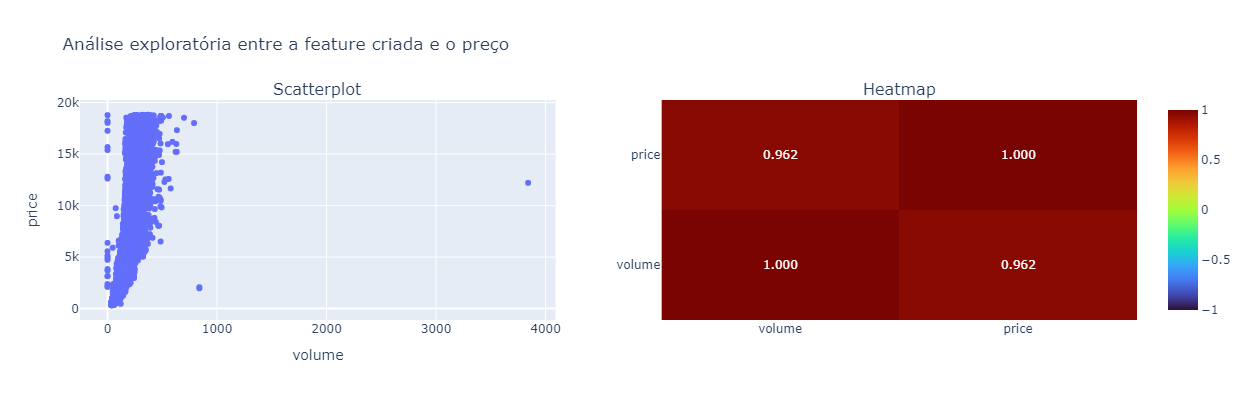

In [4]:
fig = sp.make_subplots(rows=1, cols=2, horizontal_spacing=0.1, subplot_titles=['Scatterplot', 'Heatmap'])

# Primeiro subplot
fig.add_trace(go.Scatter(x= diamonds['volume'], y=diamonds['price'], mode='markers'), row=1, col=1)

# Segundo subplot
fig.add_trace(go.Heatmap(z = diamonds[['volume', 'price']].corr('spearman'), zmin=-1, zmax=1, 
                         x = ['volume', 'price'], y = ['volume', 'price'], texttemplate="%{z:.3f}", coloraxis="coloraxis"), row=1, col=2)

# Atualizando layout com rótulos dos eixos e exibição do gráfico
fig.update_layout(xaxis1_title="volume", yaxis1_title="price", height=400, width=1250, coloraxis={'colorscale': 'Turbo', 'cmin': -1, 'cmax': 1}, 
                  title= 'Análise exploratória entre a feature criada e o preço')

fig.show('png') 

- Podemos observar que o processo de Feature Engineering para criação da variável de volume tem uma correlação positiva não-linear alta em relação ao preço do diamante. Ou seja, quanto maior for o volume do diamante, maior o preço, o que faz sentido seguindo a lógica que o preço aumenta conforme o valor do diamanete. 

- O ponto interessante é que como foi imaginado, o valor do diamante aumenta de uma maneira exponencial de acordo com o seu volume, o que pode ser visto a partir do gráfico de dispersão acima.

- Sendo assim, é uma boa variável para ser considerada para o modelo preditivo.

### Features 2 e 3: Quilate com transformação logarítmica e polinomial

- Justificativa: A transformação logarítmica e polinomial de `carat` pode ajudar a linearizar sua relação com o preço, além de possivelmente reduzir o impacto de outliers e capturar eventuais efeitos não lineares do peso sobre o valor do diamante. Criarei as duas features pois minha intenção é testar essa abordagem de transformação tanto de forma logarítimica quanto polinomial e ver qual possui melhor relação com o target.

- Variável utilizada: `carat`

In [5]:
import math

def apply_log(X):
    return math.log(X, 10) 

def apply_poly(X):
    return X**2

diamonds['log_carat'] = diamonds['carat'].apply(lambda k: apply_log(k))
diamonds['carat²'] = diamonds['carat'].apply(lambda k: apply_poly(k))

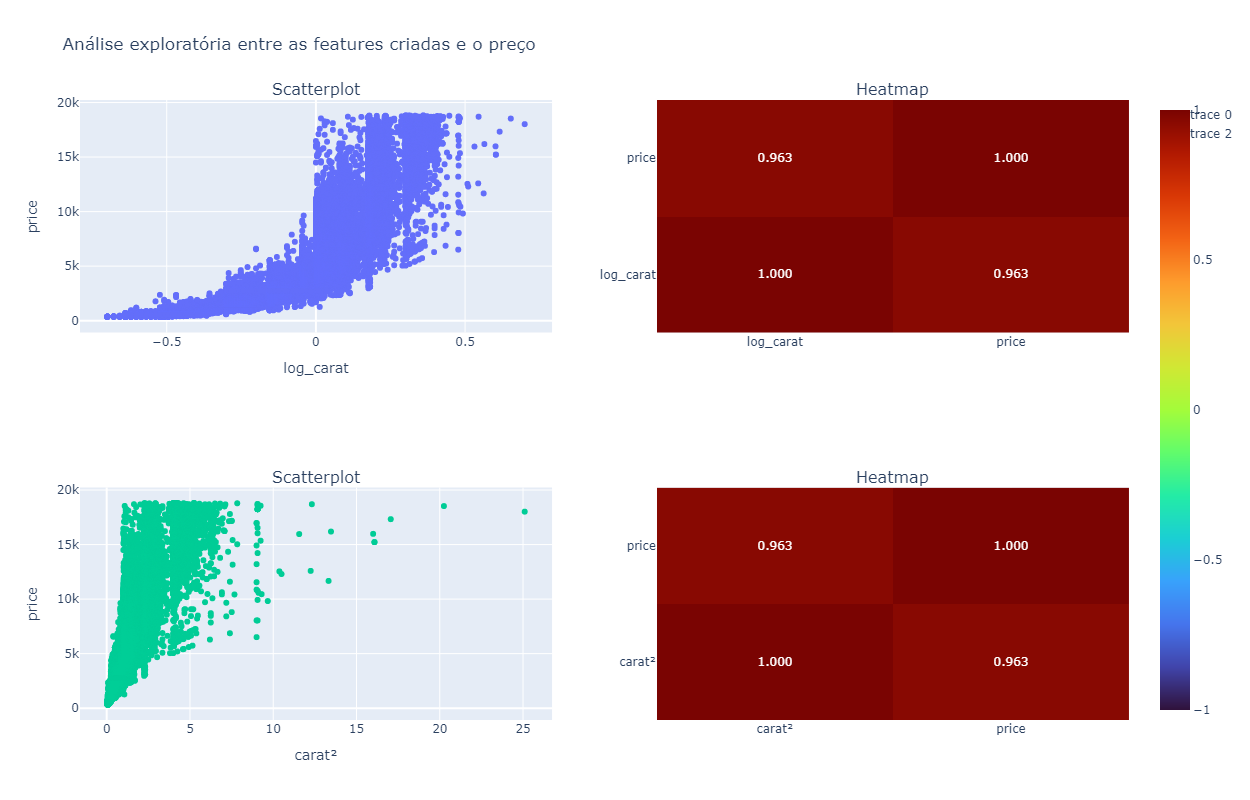

In [6]:
fig = sp.make_subplots(rows=2, cols=2, horizontal_spacing=0.1, subplot_titles=['Scatterplot', 'Heatmap', 'Scatterplot', 'Heatmap'], vertical_spacing=0.25)

# Primeiro subplot
fig.add_trace(go.Scatter(x= diamonds['log_carat'], y=diamonds['price'], mode='markers'), row=1, col=1)

# Segundo subplot
fig.add_trace(go.Heatmap(z = diamonds[['log_carat', 'price']].corr('spearman'), zmin=-1, zmax=1, 
                         x = ['log_carat', 'price'], y = ['log_carat', 'price'], texttemplate="%{z:.3f}", coloraxis="coloraxis"), row=1, col=2)

# Terceiro subplot
fig.add_trace(go.Scatter(x= diamonds['carat²'], y=diamonds['price'], mode='markers'), row=2, col=1)

# Quarto subplot
fig.add_trace(go.Heatmap(z = diamonds[['carat²', 'price']].corr('spearman'), zmin=-1, zmax=1, 
                         x = ['carat²', 'price'], y = ['carat²', 'price'], texttemplate="%{z:.3f}", coloraxis="coloraxis"), row=2, col=2)

# Atualizando layout com rótulos dos eixos e exibição do gráfico
fig.update_layout(xaxis1_title="log_carat", yaxis1_title="price", xaxis3_title="carat²", yaxis3_title="price", 
                  height=800, width=1250, coloraxis={'colorscale': 'Turbo', 'cmin': -1, 'cmax': 1}, 
                  title= 'Análise exploratória entre as features criadas e o preço')

fig.show('png') 

- Acima foram feitas as transformações da variável `carat` por meio da transformação logarítmica e quadrática, gerando duas novas variáveis. Considerando esse contexto, faz sentido que essas variáveis apresentem relações não lineares (como observado nos gráficos de dispersão). Por esse motivo, foi aplicada a correlação de Spearman no heatmap, uma vez que ela é adequada para capturar relações monotônicas, que podem ser não lineares. Diferentemente da correlação de Pearson, que assume uma relação linear e exige que ambas as variáveis possuam distribuição aproximadamente normal.

- A respeito das correlações, observa-se uma correlação positiva, monotônica e alta para ambas as variáveis, assim como foi observado anteriormente com a feature volume. Como ambas as variáveis são transformações diferentes da variável `carat` em escalas distintas, seus valores numéricos no gráfico de dispersão são diferentes, mas a correlação permanece praticamente a mesma, já que ambas medem essencialmente a mesma informação. 

- Portanto, seria interessante considerar uma ou outra na próxima etapa de modelagem preditiva, evitando a inclusão simultânea devido à alta multicolinearidade entre elas.

## 2. Classificação Ordinal Multi-classes

### Configurações experimentais (Pré-processamento)

In [7]:
filename = 'A652.pickle'

f = open(filename, 'rb')

(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(f)
print("Shapes: ", X_train.shape, X_val.shape, X_test.shape)

Shapes:  (10012, 24) (2506, 24) (9582, 24)


In [8]:
# Função para transformar os targets númericos y_* em categórico de acordo com os ranges do enunciado
def numerical_to_categorical(y):
    """    
    Função para categorizar as faixas de valores do target númerico
    
    0           -> 'None'
    (0, 5]      -> 'Weak'
    (5, 25]     -> 'Moderate'
    (25, 50]    -> 'Strong'
    (50, +inf]  -> 'Extreme'
    """

    conditions = [
        y == 0,
        (y > 0) & (y <= 5),
        (y > 5) & (y <= 25),
        (y > 25) & (y <= 50),
        y > 50
    ]

    choices = ['None', 'Weak', 'Moderate', 'Strong', 'Extreme']

    return np.select(conditions, choices, default='Unknown')

In [9]:
# Transformação dos ranges númericos dos targets de treino, validação e teste em categorias
y_train_cat = numerical_to_categorical(y_train.ravel())
y_test_cat = numerical_to_categorical(y_test.ravel())

print('y_train:\n', pd.Series(y_train_cat).value_counts())
print('\ny_test:\n', pd.Series(y_test_cat).value_counts())

y_train:
 None        9258
Weak         664
Moderate      88
Strong         2
Name: count, dtype: int64

y_test:
 None        8769
Weak         757
Moderate      50
Strong         4
Extreme        2
Name: count, dtype: int64


In [10]:
y_test_cat = np.where(y_test_cat == 'Extreme', 'Strong', y_test_cat)
print('\ny_test:\n', pd.Series(y_test_cat).value_counts())


y_test:
 None        8769
Weak         757
Moderate      50
Strong         6
Name: count, dtype: int64


- Como não há a classe 'Extreme' no conjunto de treino, isso pode gerar problemas na etapa de predição multiclasse ordinal, pois existe um ponto em que é criado um target para comparar 'Target > Classe?' e isso irá gerar um target apenas constituído por zero a partir do 'Strong', pois não há nenhum valor acima dele igual a 1 no conjunto de treino, dando erro no algoritmo do GradientBoostClassifier. Logo, para evitar esse problema, substitui o 'Extreme' para a classe 'Strong'.

In [11]:
# Define a ordem das categorias e aplica o OrdinalEncoder para codificar as categorias do targets em um númerica ordinal
# O OrdinalEnconder foi aplicado de uma forma que evitasse DataLeakage
categories_order = [['None', 'Weak', 'Moderate', 'Strong', 'Extreme']]
encoder = OrdinalEncoder(categories=categories_order)

y_train_ord = pd.Series(encoder.fit_transform(y_train_cat.reshape(-1, 1)).astype(int).ravel())
y_test_ord = pd.Series(encoder.transform(y_test_cat.reshape(-1, 1)).astype(int).ravel())

print('y_train:\n', y_train_ord.value_counts())
print('\ny_test:\n', y_test_ord.value_counts())

y_train:
 0    9258
1     664
2      88
3       2
Name: count, dtype: int64

y_test:
 0    8769
1     757
2      50
3       6
Name: count, dtype: int64


- Podemos observar que a classe majoritária nas duas porções é a 'None' (classe 0), o que significa que a maior parte dos dados representa momentos sem chuva. O desbalanceamento é evidente e pode prejudicar a performance dos modelos de Machine Learning.

- Outro ponto a se notar é que a categoria 'Extreme' (classe 4) é tão rara que não possui registros nas porções de treino, aparecendo apenas duas vezes no conjunto de teste. Isso indica que o modelo provavelmente não terá a oportunidade de aprender sobre essa classe, sendo assim, tenderá a "chutar" um valor para ela.

### Modelagem preditiva Baseline (Multiclassificação normal)

#### Treinamento e predição

In [12]:
def plot_confusion_matrix_class_report(y_test, y_pred, labels=None, target_names=None):
    """
    
    Função para obter a matriz de confusão e classification_report

    """
    #Confusion metrics of the model built on down-sampled data
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=labels)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', color="white" if conf_matrix[i, j] > conf_matrix.max()/2 else "black")
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

    print(classification_report(y_test, y_pred, labels=labels, target_names=target_names))

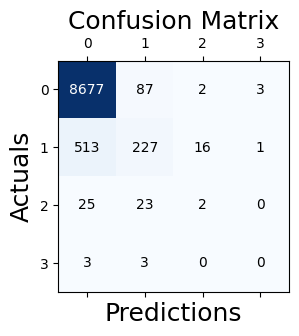

              precision    recall  f1-score   support

        None       0.94      0.99      0.96      8769
        Weak       0.67      0.30      0.41       757
    Moderate       0.10      0.04      0.06        50
      Strong       0.00      0.00      0.00         6

    accuracy                           0.93      9582
   macro avg       0.43      0.33      0.36      9582
weighted avg       0.91      0.93      0.92      9582



In [13]:
# Treinamento do modelo
model = GradientBoostingClassifier(random_state=seed)
model.fit(X_train, y_train_ord)

# Teste
y_pred_test = model.predict(X_test)

y_pred = encoder.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()
y_true = encoder.inverse_transform(y_test_ord.to_numpy().reshape(-1, 1)).ravel()

labels = ['None', 'Weak', 'Moderate', 'Strong']
plot_confusion_matrix_class_report(y_true, y_pred, labels=labels, target_names=labels)

#### Análise dos resultados

- A partir da modelagem baseline de classificação multiclasse, considerando o target como uma variável categórica nominal, o GradientBoostingClassifier adota uma metodologia interna que permite o treinamento com um target não binário. A partir disso, observamos que a acurácia resultante foi bastante alta. No entanto, essa métrica não pode ser considerada confiável, uma vez que há um desbalanceamento acentuado entre as classes, o que favorece o modelo a acertar frequentemente ao simplesmente prever a classe 0. Para uma avaliação mais robusta, será utilizado principalmente o f1-score por classe.

- Considerando que o objetivo é prever se haverá chuva, as classes mais relevantes a serem previstas são da 1 à 4. Essas classes apresentam, teoricamente, uma ordem de importância a ser considerada, sendo cada vez mais interessante prever corretamente as classes superiores, pois representam eventos mais raros. Porém, para essa modelagem baseline isso não foi considerado. No entanto, ess

    Como observado anteriormente, a raridade de classes implica em menos amostras disponíveis para o treinamento do modelo. Logo, o conjunto de treinamento possuiu apenas dois exemplos para a classe 3 e nenhum exemplo para a classe 4, o que justifica o f1-score de 0% para essas duas classes mais raras, pois o modelo não teve informações suficientes (ou nenhuma) para aprender a predizê-las, sofrendo assim com underfitting e um grande desbalanceamento. O mesmo ocorreu em menor grau com a classe 2, que contou com poucos exemplos no treino e teste, resultando em um desempenho igualmente baixo e quase nulo.

    Por fim, a segunda melhor classe em desempenho foi a classe 1, a qual apresentou a segunda maior quantidade de exemplos. O modelo pôde realizar um treinamento mais adequado sobre essa classe, alcançando um F1-score de 41%.

### Modelagem preditiva principal (Multiclassificação ordinal)

#### Treinamento e predição

In [14]:
def predict_ordinal_proba(X, models):
    """
    Combina as previsões dos modelos binários para estimar as probabilidades de cada classe ordinal.
    """
    m = len(models) + 1  # número total de classes
    n = X.shape[0]       # número de instâncias
    probas = np.zeros((n, m))  # matriz de probabilidades finais

    # Obtemos P(y > i) de cada classificador binário
    prob_gt = [model.predict_proba(X)[:, 1] for model in models]

    # Probabilidade da primeira classe (ex: 'None') é: 1 - P(y > 0)
    probas[:, 0] = 1 - prob_gt[0]

    # Classes intermediárias: P(y = i) = P(y > i−1) * (1 − P(y > i))
    for i in range(1, m - 1):
        probas[:, i] = prob_gt[i - 1] * (1 - prob_gt[i])

    # Última classe é simplesmente P(y > m−2), pois é teoricamente o restante
    probas[:, m - 1] = prob_gt[-1]

    return probas

Target index: 0
Valores por classe:
 0    9258
1     664
2      88
3       2
Name: count, dtype: int64
Classe > i?:
 0    9258
1     754
Name: count, dtype: int64
--------------

Target index: 1
Valores por classe:
 0    9258
1     664
2      88
3       2
Name: count, dtype: int64
Classe > i?:
 0    9922
1      90
Name: count, dtype: int64
--------------

Target index: 2
Valores por classe:
 0    9258
1     664
2      88
3       2
Name: count, dtype: int64
Classe > i?:
 0    10010
1        2
Name: count, dtype: int64
--------------



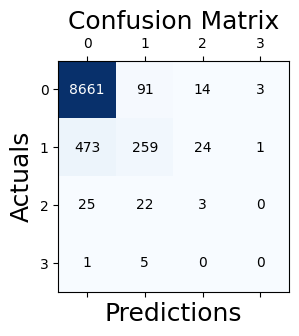

              precision    recall  f1-score   support

        None       0.95      0.99      0.97      8769
        Weak       0.69      0.34      0.46       757
    Moderate       0.07      0.06      0.07        50
      Strong       0.00      0.00      0.00         6

    accuracy                           0.93      9582
   macro avg       0.43      0.35      0.37      9582
weighted avg       0.92      0.93      0.92      9582



In [15]:
m = y_train_ord.nunique()
models = []

# Para cada limiar i (i = 0 até m−2), criamos um modelo que responde: "Classe > i?"
for i in range(m - 1):
    print('Target index:', i)
    print('Valores por classe:\n', y_train_ord.value_counts())
    y_binary = (y_train_ord > i).astype(int)  # binariza o target: 1 se classe > i, senão 0

    print('Classe > i?:\n', y_binary.value_counts())
    clf = GradientBoostingClassifier(random_state=seed)
    clf.fit(X_train, y_binary)  # Treina modelo binário para esse limiar
    models.append(clf)
    print('--------------\n')

# Estima as probabilidades finais por classe
probas_test = predict_ordinal_proba(X_test, models)

# A classe final é aquela com maior probabilidade (argmax)
y_pred_ord = np.argmax(probas_test, axis=1)

# Decodifica os rótulos numéricos de volta para nomes de classe
y_pred_labels = encoder.inverse_transform(y_pred_ord.reshape(-1, 1)).ravel()
y_true_labels = encoder.inverse_transform(y_test_ord.to_numpy().reshape(-1, 1)).ravel()

labels = ['None', 'Weak', 'Moderate', 'Strong']
plot_confusion_matrix_class_report(y_true_labels, y_pred_labels, labels=labels, target_names=labels)

#### Análise dos resultados

- Por meio da metodologia de classificação ordinal multiclasse abordada no artigo, foi realizada a modelagem para cada dataset associado a uma tarefa binária do tipo "Classe > i?", sendo atribuído o valor 1 nos casos em que a classe está acima na hierarquia ordinal, e 0 caso contrário. Esse processo foi repetido para cada uma das classes, exceto para a última (no caso, 'Strong') pois não há valores superiores a ela, então não faria sentido. A partir dessa modelagem, foi possível estimar as probabilidades para cada uma das classes, sendo escolhida como classificação final aquela com maior probabilidade entre todas, para cada exemplo no conjunto de teste.

- Em relação aos resultados metrificados pelo f1-score principalmente, observa-se que, assim como na abordagem tradicional (baseline), o desbalanceamento dos dados continua sendo um problema predominante, fazendo com que a classe 'None' tenha desempenho significativamente superior, enquanto as demais apresentem métricas mais baixas, como é o caso da classe 'Strong', que teve apenas 2 exemplos no conjunto de treinamento.

    Considerando o respeito à ordem entre as classes proporcionado por essa metodologia alternativa, percebe-se que, apesar do desbalanceamento favorecer classificações para a classe majoritária, houve uma melhora no f1-score da classe 'Weak', passando de 41% para 46% (um aumento de 5%), e da classe 'Moderate', de 6% para 7% (um aumento de 1%). Esses resultados indicam que a segunda abordagem é útil para capturar nuances nos dados ordinais que não foram percebidas no baseline, devido ao fato de este tratar o target como se fosse uma variável nominal.

## 3. SHAP Values

In [16]:
# Questão anulada.

## 4. Redução de Dimensionalidade

- Para essa questão, irei repetir o processo de pré-processamento que foi feita na questão 2 e a função de classificação ordinal multiclasse, porém agora incluindo o conjunto de validação pois será feito o three-way holdout. Além disso, irei reaproveitar a função para categorizar o target.

### Configurações experimentais (Pré-processamento)

In [17]:
filename = 'A652.pickle'

f = open(filename, 'rb')

(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(f)

# Transformação dos ranges númericos dos targets de treino, validação e teste em categorias
y_train_cat = numerical_to_categorical(y_train.ravel())
y_val_cat = numerical_to_categorical(y_val.ravel())
y_test_cat = numerical_to_categorical(y_test.ravel())

print('y_train:\n', pd.Series(y_train_cat).value_counts())
print('\ny_val:\n', pd.Series(y_val_cat).value_counts())
print('\ny_test:\n', pd.Series(y_test_cat).value_counts())

# Define a ordem das categorias e aplica o OrdinalEncoder para codificar as categorias do targets em um númerica ordinal
# O OrdinalEnconder foi aplicado de uma forma que evitasse DataLeakage
categories_order = [['None', 'Weak', 'Moderate', 'Strong', 'Extreme']]
encoder = OrdinalEncoder(categories=categories_order)

y_train:
 None        9258
Weak         664
Moderate      88
Strong         2
Name: count, dtype: int64

y_val:
 None        2277
Weak         222
Moderate       6
Strong         1
Name: count, dtype: int64

y_test:
 None        8769
Weak         757
Moderate      50
Strong         4
Extreme        2
Name: count, dtype: int64


In [18]:
y_test_cat = np.where(y_test_cat == 'Extreme', 'Strong', y_test_cat)
print('\ny_test:\n', pd.Series(y_test_cat).value_counts())


y_test:
 None        8769
Weak         757
Moderate      50
Strong         6
Name: count, dtype: int64


- Nessa parte foi repetido o agrupamento do 'Extreme' para 'Strong' com o intuito de não impactar a etapa de classificação ordinal multiclasse. A porção de validação, assim como a de treino, não possui a classe 'Extreme', logo não foi necessário realizar esse procedimento para a mesma.

In [19]:
y_train_ord = pd.Series(encoder.fit_transform(y_train_cat.reshape(-1, 1)).astype(int).ravel())
y_val_ord = pd.Series(encoder.transform(y_val_cat.reshape(-1, 1)).astype(int).ravel())
y_test_ord = pd.Series(encoder.transform(y_test_cat.reshape(-1, 1)).astype(int).ravel())

print('y_train:\n', y_train_ord.value_counts())
print('\ny_val:\n', y_val_ord.value_counts())
print('\ny_test:\n', y_test_ord.value_counts())

y_train:
 0    9258
1     664
2      88
3       2
Name: count, dtype: int64

y_val:
 0    2277
1     222
2       6
3       1
Name: count, dtype: int64

y_test:
 0    8769
1     757
2      50
3       6
Name: count, dtype: int64


### Modelagem Preditiva Ordinal Multiclasse Baseline

#### Treinamento e predição

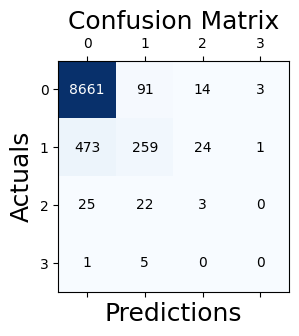

              precision    recall  f1-score   support

        None       0.95      0.99      0.97      8769
        Weak       0.69      0.34      0.46       757
    Moderate       0.07      0.06      0.07        50
      Strong       0.00      0.00      0.00         6

    accuracy                           0.93      9582
   macro avg       0.43      0.35      0.37      9582
weighted avg       0.92      0.93      0.92      9582



In [20]:
m = y_train_ord.nunique()
models = []

# Para cada limiar i (i = 0 até m−2), criamos um modelo que responde: "Classe > i?"
for i in range(m - 1):
    
    y_binary = (y_train_ord > i).astype(int)  # binariza o target: 1 se classe > i, senão 0
    clf = GradientBoostingClassifier(random_state=seed)
    clf.fit(X_train, y_binary)  # Treina modelo binário para esse limiar
    models.append(clf)

# Estima as probabilidades finais por classe
probas_test = predict_ordinal_proba(X_test, models)

# A classe final é aquela com maior probabilidade (argmax)
y_pred_ord = np.argmax(probas_test, axis=1)

# Decodifica os rótulos numéricos de volta para nomes de classe
y_pred_labels = encoder.inverse_transform(y_pred_ord.reshape(-1, 1)).ravel()
y_true_labels = encoder.inverse_transform(y_test_ord.to_numpy().reshape(-1, 1)).ravel()

labels = ['None', 'Weak', 'Moderate', 'Strong']
plot_confusion_matrix_class_report(y_true_labels, y_pred_labels, labels=labels, target_names=labels)

- Como observado na questão 2, a metodologia de classificação ordinal multiclasse não conseguiu prever a classe 'Strong', o que é compreensível considerando a quantidade extremamente baixa de exemplos disponíveis para o treinamento. Isso resultou em um f1-score muito baixo para essa classe. Além disso, 'None' se mostrou como a classe majoritária, apresentando um evidente desbalanceamento, o que também limita sua utilidade como métrica de avaliação. Dessa forma, 'Weak' e 'Moderate' foram os principais indicadores de performance, com f1-scores de 46% e 7%, respectivamente.

- A partir desse resultado de baseline, será avaliado se a abordagem com redução de dimensionalidade por meio de componentes principais (PCA) pode oferecer uma alternativa mais eficaz.

### Modelagem Preditiva Ordinal Multiclasse Principal (three-way holdout com k ótimo de componentes principais)

#### Treino e validação em busca do melhor k

In [21]:
dimensions_max_len = X_train.shape[1]

# Define os pesos por classe
class_weights = {'Weak': 1, 'Moderate': 2, 'Strong': 3}

result = {
    'k': [],
    'weighted_f1': []
}

for k in range(1, dimensions_max_len + 1):

    result['k'].append(k)

    m = y_train_ord.nunique()
    models = []

    for i in range(m - 1):
        y_binary = (y_train_ord > i).astype(int)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=k, random_state=seed)),
            ('clf', GradientBoostingClassifier(random_state=seed))
        ])

        pipeline.fit(X_train, y_binary)
        models.append(pipeline)

    probas_val = predict_ordinal_proba(X_val, models)
    y_pred_ord = np.argmax(probas_val, axis=1)

    y_pred_labels = encoder.inverse_transform(y_pred_ord.reshape(-1, 1)).ravel()
    y_true_labels = encoder.inverse_transform(y_val_ord.to_numpy().reshape(-1, 1)).ravel()

    # Calcula f1 por classe
    report = classification_report(y_true_labels, y_pred_labels, output_dict=True, zero_division=0)

    # Calcula a média ponderada manual
    weighted_f1 = 0
    total_peso = 0

    for classe, peso in class_weights.items():
        f1 = report.get(classe, {}).get('f1-score', 0.0)
        weighted_f1 += f1 * peso
        total_peso += peso

    f1_final = weighted_f1 / total_peso if total_peso > 0 else 0
    result['weighted_f1'].append(f1_final)

- Essa etapa teve como objetivo aplicar a metodologia introduzida na questão 2, porém agora o modelo foi construído para cada valor de k, sendo k a quantidade de componentes principais. Assim, o processo foi repetido 24 vezes, correspondendo ao número de colunas presentes em X. Para aplicar corretamente o PCA, utilizei o StandardScaler para padronizar os dados antes da redução de dimensionalidade.

- Para avaliar o resultado de cada modelagem com k componentes principais, utilizei a métrica f1-score, como feito anteriormente. No entanto, desta vez, em vez de analisar o classification report individualmente para cada caso, optei por automatizar o processo com uma média ponderada, atribuindo pesos da classe mais rara até a menos rara, porém ignorando a classe majoritária e dando foco apenas as restantes. Isso permite identificar qual modelagem conseguiu melhor desempenho nas classes mais difíceis de prever.

- Ao final, foi gerado um dicionário contendo os valores de k e os respectivos f1-scores ponderados. Essa estrutura será utilizada para identificar o melhor valor de k e, com isso, realizar a avaliação principal, comparando os resultados com o baseline, que utilizou um two-way holdout sem aplicação de PCA.

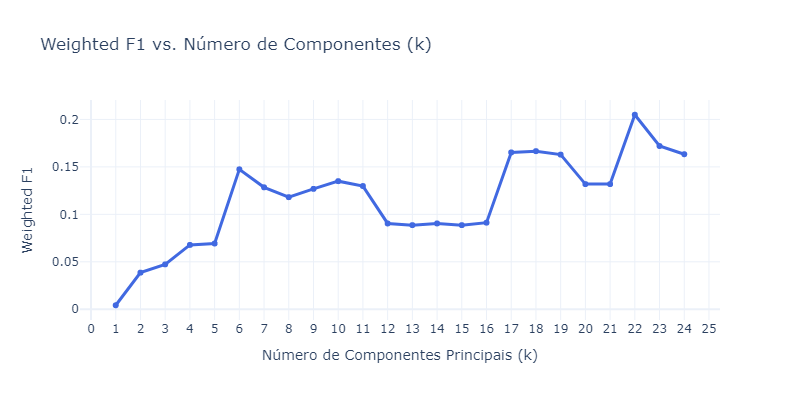

In [22]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=result['k'], y=result['weighted_f1'], mode='lines+markers', name='Weighted F1', line=dict(color='royalblue', width=3), marker=dict(size=6)))

fig.update_layout(title='Weighted F1 vs. Número de Componentes (k)', xaxis_title='Número de Componentes Principais (k)', 
                  yaxis_title='Weighted F1', xaxis=dict(tickmode='linear'), template='plotly_white', height=400, width=800)

fig.show('png')

- Podemos observar que o melhor k corresponde a um tamanho de 22, ou seja, a melhor modelagem na etapa de validação foi com 22 componentes principais com um f1-score ponderado de aproximadamente 20%.

#### Avaliação Final

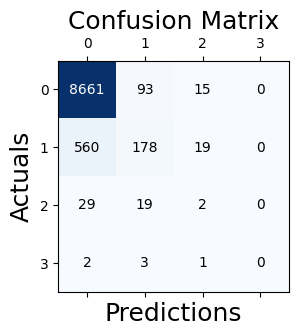

              precision    recall  f1-score   support

        None       0.94      0.99      0.96      8769
        Weak       0.61      0.24      0.34       757
    Moderate       0.05      0.04      0.05        50
      Strong       0.00      0.00      0.00         6

    accuracy                           0.92      9582
   macro avg       0.40      0.32      0.34      9582
weighted avg       0.90      0.92      0.91      9582



In [23]:
m = y_train_ord.nunique()
models = []

for i in range(m - 1):
    y_binary = (y_train_ord > i).astype(int)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=22, random_state=seed)),
        ('clf', GradientBoostingClassifier(random_state=seed))
    ])

    pipeline.fit(X_train, y_binary)
    models.append(pipeline)

probas_test = predict_ordinal_proba(X_test, models)
y_pred_ord = np.argmax(probas_test, axis=1)

y_pred_labels = encoder.inverse_transform(y_pred_ord.reshape(-1, 1)).ravel()
y_true_labels = encoder.inverse_transform(y_test_ord.to_numpy().reshape(-1, 1)).ravel()

labels = ['None', 'Weak', 'Moderate', 'Strong']
plot_confusion_matrix_class_report(y_true_labels, y_pred_labels, labels=labels, target_names=labels)

#### Análise dos resultados

- A partir da utilização do conjunto de teste com a melhor quantidade de k componentes principais, observou-se que as classes 'Weak' e 'Moderate' apresentaram desempenhos de 34% e 5%, respectivamente. Esses resultados foram inferiores aos obtidos pelo método que não aplicou a redução de dimensionalidade. Isso indica que as variáveis em seu formato original mantêm uma relação mais eficaz com o modelo durante as fases de treinamento e predição das diferentes classes.

## 5. Predição Conforme

### Configurações Experimentais (Pré-processamento)

In [24]:
diamonds = pd.read_csv('../data/diamonds.csv', index_col=0)
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [25]:
# Divisão do conjunto de treino em X (features) e y (target)
X = diamonds.drop('price', axis=1)
y = diamonds['price']

# Criando uma lista de nomes das features númericas que irão ser codificadas com o StandardScaler
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z']

# Criando uma lista de nomes das features categóricas ordinais que irão ser codificadas com o OrdinalEncoder
categorical_features = ['cut', 'color', 'clarity']

# Define a order para cada coluna categórica (Pior -> Melhor)
categories_order = [
    ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],  # Ordem para 'cut' 
    ['J', 'I', 'H', 'G', 'F', 'E', 'D'],  # Ordem para 'color'
    ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']  # Ordem para 'clarity'
]

model = GradientBoostingRegressor(random_state=seed)

# Divisão do conjunto de treino em treino/validação com uma porcentagem de treino em 20%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)


# Etapa de transformação apenas das features númericas utilizando o StandardScaler
transformer = ColumnTransformer(transformers=[('scaler', StandardScaler(), numerical_features),
                                             ('ordinal_encoder', OrdinalEncoder(categories=categories_order), categorical_features)])

# Realizando a transformação nas features de treino e validação da forma correta para evitar data leakage
X_train = transformer.fit_transform(X_train)
X_calib = transformer.transform(X_calib)
X_test = transformer.transform(X_test)

### Modelagem preditiva

In [54]:
# Parâmetros
alpha = 0.1
lower_alpha = alpha / 2      # 0.05
upper_alpha = 1 - alpha / 2  # 0.95

# 1. Treinar regressão para limites inferior e superior
lower_model = GradientBoostingRegressor(loss='quantile', alpha=lower_alpha, random_state=seed)
upper_model = GradientBoostingRegressor(loss='quantile', alpha=upper_alpha, random_state=seed)

# Treina nos dados de treino
lower_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)

# 2. Previsões no conjunto de calibração
y_calib_lower = lower_model.predict(X_calib)
y_calib_upper = upper_model.predict(X_calib)

# 3. Nonconformity scores: erro máximo além dos quantis
scores = np.maximum(y_calib_lower - y_calib, y_calib - y_calib_upper)

# 4. Quantil dos scores para ajustar o intervalo (garantindo cobertura)
q = np.quantile(scores, 1 - alpha)

# 5. Previsões no conjunto de teste
y_test_lower = lower_model.predict(X_test)
y_test_upper = upper_model.predict(X_test)

# 6. Ajustar os intervalos com o q calibrado
y_lower = y_test_lower - q
y_upper = y_test_upper + q

# 7. Avaliar cobertura
cobertura = np.mean((y_test >= y_lower) & (y_test <= y_upper))
print(f'Cobertura empírica: {round(cobertura, 3)}')

# 8. Identificar maior e menor intervalo
interval_widths = y_upper - y_lower
max_idx = np.argmax(interval_widths)
min_idx = np.argmin(interval_widths)

print(f"\nMenor intervalo: largura = {interval_widths[min_idx]:.2f}")
print(f"Valor real = {y_test.iloc[min_idx]:.2f}, Conjunto predito ≈ [{y_lower[min_idx]:.2f}, {y_upper[min_idx]:.2f}]")

print(f"\nMaior intervalo: largura = {interval_widths[max_idx]:.2f}")
print(f"Valor real = {y_test.iloc[max_idx]:.2f}, Conjunto predito ≈ [{y_lower[max_idx]:.2f}, {y_upper[max_idx]:.2f}]") 

Cobertura empírica: 0.899

Menor intervalo: largura = 67.70
Valor real = 1040.00, Conjunto predito ≈ [797.78, 865.48]

Maior intervalo: largura = 14495.11
Valor real = 18102.00, Conjunto predito ≈ [5502.68, 19997.79]


#### Análise dos resultados

- Utilizando a técnica de Conformalized Quantile Regression, foi possível gerar intervalos de predição individualizados para cada exemplo do conjunto de teste. Essa abordagem permite que os limites de incerteza variem conforme a dificuldade de prever cada exemplo.

- Ao aplicar a técnica de conformal prediction com alpha = 0.1, obteve-se uma cobertura empírica de ~0.9 no conjunto de teste. Isso indica que aproximadamente 9 em cada 10 predições geraram intervalos que contêm o valor real do preço do diamante, o que está em conformidade com o nível de confiança teórico de 90%. que foi definido.

- **Menor intervalo**:
    - O modelo teve alta confiança na predição. O intervalo gerado é estreito e o valor real ficou fora do intervalo predito, mas relativamente próximo dele. Isso indica que, embora o modelo estivesse razoavelmente certo sobre a estimativa com um pequeno erro sistemático.

- **Maior intervalo**:
    - O modelo demonstrou alta incerteza. O intervalo é bastante largo, refletindo que, para essa instância específica, o modelo reconheceu grande variabilidade nos possíveis valores do alvo. Ainda assim, o valor real ficou dentro do intervalo.